## step1. 데이터 로드

In [1]:
import pandas as pd
import numpy as np
from isoweek import Week
import time
from pandas import Series, DataFrame
from collections import OrderedDict
import matplotlib.pyplot as plt

In [2]:
actualData = pd.read_csv("./dataset/pro_actual_sales.csv")

In [3]:
actualData.head()

,regionSeg1,productSeg1,productSeg2,regionSeg2,regionSeg3,productSeg3,yearweek,year,week,qty
0,A01,NaN,PG05,SALESID0001,SITEID0004,ITEM0445,201306,2013,6,5
1,A01,NaN,PG05,SALESID0001,SITEID0004,ITEM0445,201307,2013,7,8
2,A01,NaN,PG05,SALESID0001,SITEID0004,ITEM0445,201308,2013,8,7
3,A01,NaN,PG05,SALESID0001,SITEID0004,ITEM0445,201309,2013,9,1
4,A01,NaN,PG05,SALESID0001,SITEID0004,ITEM0445,201310,2013,10,1


In [4]:
actualData.dtypes

regionSeg1      object
productSeg1    float64
productSeg2     object
regionSeg2      object
regionSeg3      object
productSeg3     object
yearweek         int64
year             int64
week             int64
qty              int64
dtype: object

In [5]:
len(actualData.index)

140867

## step2. 데이터 정제

### step.2-1. 빈주차 생성

In [6]:
## postWeek 함수 생성 

def postWeek(inputYW, gapWeek) :
    inputYW = str(inputYW)
    inputY = inputYW[0:4]
    inputW = inputYW[4:]
    
    gapWeek = int(gapWeek)
    
    sumWeek = int(inputW) + gapWeek
    
    currYear = int(inputY)
    lastWeek = Week.last_week_of_year(currYear).week
    
    while(sumWeek > lastWeek) :
        sumWeek -= lastWeek
        currYear += 1
        lastWeek = Week.last_week_of_year(currYear).week
        
    if(sumWeek < 10) :
        lastAnswer = str(currYear) + "0" + str(sumWeek)
    else :
        lastAnswer = str(currYear) + str(sumWeek)
    
    return lastAnswer

### ----minmaxweek 함수 수정전----

In [7]:
## minmaxweek 함수 생성 : groupby를 적용한 데이터셋에 빈주차를 파악하여 최종적으로 채워주는 함수
## step1. yearweek의 min값과 max값을 찾아 그 사이에 있는 연주차를 모두 생성하여 배열에 담는다
## step2.비어있는주차가 존재하는 df와 step1에서 만든 배열의 차집합을 구하여 빈주차값을 알아본다
## step3. step2에서 구한 빈주차를 df에 적용시킨다(그룹별로 적용됨)

# def minmaxweek(inputdf) :
#     inputdf.reset_index(drop = True, inplace = True)
    
#     minYW = min(inputdf['yearweek']) 
#     maxYW = 201627 ##전체 ITEM의 확정된 maxYW 
#     fullYearWeek = []
#     fullYearWeek.append(minYW)
    
#     while(max(fullYearWeek) < maxYW) :
#         inputYW = int(postWeek(max(fullYearWeek),1))
#         fullYearWeek.append(inputYW)
        
#     diffYearWeek = list(set(fullYearWeek).difference(set(list(inputdf.yearweek.values)))) #difference는 set형식에서만 사용할 수 있음
    
#     for i in range(len(diffYearWeek)) :
#         inputdf.loc[len(inputdf)] = list(inputdf.loc[0].values)
#         inputdf.loc[len(inputdf)-1, 'yearweek'] = diffYearWeek[i]
#         inputdf.loc[len(inputdf)-1, 'year'] = int(diffYearWeek[i]/100) ##round 처리 말고 int처리로 변경
#         inputdf.loc[len(inputdf)-1, 'week'] = diffYearWeek[i]%100
#         inputdf.loc[len(inputdf)-4, 'qty'] = 0
    
#     #어차피 이 함수 적용하고나서 다시 sort 해줘야하기때문에 생략해도 될 것 같음
# #     inputdf.sort_values('yearweek')
# #     inputdf.reset_index(drop = True, inplace = True)
    
#     return inputdf

In [8]:
# 다른 처리
# minmaxweek 함수 생성 : groupby를 적용한 데이터셋에 빈주차를 파악하여 최종적으로 채워주는 함수
# step1. yearweek의 min값과 max값을 찾아 그 사이에 있는 연주차를 모두 생성하여 배열에 담는다
# step2.비어있는주차가 존재하는 df와 step1에서 만든 배열의 차집합을 구하여 빈주차값을 알아본다
# step3. step2에서 구한 빈주차를 df에 적용시킨다(그룹별로 적용됨)

def minmaxweek(inputdf) :
    inputdf.reset_index(drop = True, inplace = True)
    
    minYW = min(inputdf['yearweek']) 
    maxYW = 201627 ##전체 ITEM의 확정된 maxYW 
    fullYearWeek = []
    fullYearWeek.append(minYW)
    
    while(max(fullYearWeek) < maxYW) :
        inputYW = int(postWeek(max(fullYearWeek),1))
        fullYearWeek.append(inputYW)
        
    diffYearWeek = list(set(fullYearWeek).difference(set(list(inputdf.yearweek.values)))) #difference는 set형식에서만 사용할 수 있음
    

    
    result = {
        'regionSeg1': [],
        'productSeg1': [],
        'productSeg2': [],
        'regionSeg2': [],
        'regionSeg3': [],
        'productSeg3': [],
        'yearweek': [],
        'year': [],
        'week': [],
        'qty': []
    }
    
    result = OrderedDict(result) ## dict형은 입력한 값 순서대로 출력되지 않고 뒤죽박죽 => OrderedDict() 사용하여 보정
    
    baseResultList = list(inputdf.loc[0].values)
    
    for i in range(len(diffYearWeek)) :
        result['regionSeg1'].append(baseResultList[0])
        result['productSeg1'].append(baseResultList[1])
        result['productSeg2'].append(baseResultList[2])
        result['regionSeg2'].append(baseResultList[3])
        result['regionSeg3'].append(baseResultList[4])
        result['productSeg3'].append(baseResultList[5])
        result['yearweek'].append(int(int(diffYearWeek[i])))
        result['year'].append(int(diffYearWeek[i]/100))
        result['week'].append(int(diffYearWeek[i]%100))
        result['qty'].append(int(0))
    
    resultData = DataFrame(result)
    
    concatResultData = pd.concat([inputdf, resultData])
    concatResultData = concatResultData.reset_index(drop = True)
    
    concatResultData['qty'] = concatResultData['qty'].astype('int')
    concatResultData['yearweek'] = concatResultData['yearweek'].astype('int')
    concatResultData['year'] = concatResultData['year'].astype('int')
    concatResultData['week'] = concatResultData['week'].astype('int')
    
    return concatResultData

In [9]:
# baseResultList = list(actualData.loc[0].values)

In [10]:
# baseResultList

In [11]:
# baseResultList[0]

In [12]:
groupKey1 = ['regionSeg1', 'productSeg2', 'regionSeg2', 'regionSeg3', 'productSeg3']

In [13]:
start = time.time()
groupData = actualData.groupby(groupKey1).apply(minmaxweek)
end = time.time()
print(end-start)

15.359833240509033


In [14]:
sortKey = ['regionSeg1','productSeg2','regionSeg2','regionSeg3','productSeg3','yearweek']

In [15]:
sortedData = groupData.sort_values(sortKey)

In [16]:
sortedData.reset_index(drop = True, inplace =True)

In [17]:
sortedData

,regionSeg1,productSeg1,productSeg2,regionSeg2,regionSeg3,productSeg3,yearweek,year,week,qty
0,A01,NaN,PG01,SALESID0001,SITEID0001,ITEM0001,201301,2013,1,1
1,A01,NaN,PG01,SALESID0001,SITEID0001,ITEM0001,201302,2013,2,0
2,A01,NaN,PG01,SALESID0001,SITEID0001,ITEM0001,201303,2013,3,1
3,A01,NaN,PG01,SALESID0001,SITEID0001,ITEM0001,201304,2013,4,3
4,A01,NaN,PG01,SALESID0001,SITEID0001,ITEM0001,201305,2013,5,2
5,A01,NaN,PG01,SALESID0001,SITEID0001,ITEM0001,201306,2013,6,0
6,A01,NaN,PG01,SALESID0001,SITEID0001,ITEM0001,201307,2013,7,5
7,A01,NaN,PG01,SALESID0001,SITEID0001,ITEM0001,201308,2013,8,0
8,A01,NaN,PG01,SALESID0001,SITEID0001,ITEM0001,201309,2013,9,0
9,A01,NaN,PG01,SALESID0001,SITEID0001,ITEM0001,201310,2013,10,2


### step2-2. 53주차 제거

In [18]:
## week가 52주차 이하인 값들을 뽑아서 actualData에 담기
sortedData = sortedData[sortedData['week'] <= 52]
## 잘 정제 됬는지 확인
sortedData[sortedData['week'] > 52]

,regionSeg1,productSeg1,productSeg2,regionSeg2,regionSeg3,productSeg3,yearweek,year,week,qty


In [19]:
sortedData.to_csv("step2.csv")

## step3. 이동평균 구하기

In [20]:
# 그룹단위별 rolling 함수 생성
def groupRolling(oneGroup) :
    indexGroupData = oneGroup.reset_index(drop = True)
    indexGroupData['MA'] = indexGroupData['qty'].rolling(window=4, center=False, min_periods=1).mean()
    
    return indexGroupData

In [21]:
groupKey2 = ['regionSeg1', 'productSeg2', 'regionSeg3']

In [22]:
maGroup = sortedData.groupby(groupKey2).apply(groupRolling) 

In [23]:
maGroup.head()

regionSeg1  productSeg1 productSeg2  \
regionSeg1 productSeg2 regionSeg3                                         
A01        PG01        SITEID0001 0        A01          NaN        PG01   
                                  1        A01          NaN        PG01   
                                  2        A01          NaN        PG01   
                                  3        A01          NaN        PG01   
                                  4        A01          NaN        PG01   

                                      regionSeg2  regionSeg3 productSeg3  \
regionSeg1 productSeg2 regionSeg3                                          
A01        PG01        SITEID0001 0  SALESID0001  SITEID0001    ITEM0001   
                                  1  SALESID0001  SITEID0001    ITEM0001   
                                  2  SALESID0001  SITEID0001    ITEM0001   
                                  3  SALESID0001  SITEID0001    ITEM0001   
                                  4  SALESID0001  SITEID0001    ITEM0001   

                                     yearweek  year  week  qty        MA  
regionSeg1 productSeg2 regionSeg3                                         
A01        PG01        SITEID0001 0    201301  2013     1    1  1.000000  
                                  1    201302  2013     2    0  0.500000  
                                  2    201303  2013     3    1  0.666667  
                                  3    201304  2013     4    3  1.250000  
                                  4    201305  2013     5    2  1.500000

## 4. 각 년도의 주차별 seasonality 산출

In [24]:
maGroup['seasonality'] = maGroup['qty']/maGroup['MA']

In [25]:
maGroup.head()

regionSeg1  productSeg1 productSeg2  \
regionSeg1 productSeg2 regionSeg3                                         
A01        PG01        SITEID0001 0        A01          NaN        PG01   
                                  1        A01          NaN        PG01   
                                  2        A01          NaN        PG01   
                                  3        A01          NaN        PG01   
                                  4        A01          NaN        PG01   

                                      regionSeg2  regionSeg3 productSeg3  \
regionSeg1 productSeg2 regionSeg3                                          
A01        PG01        SITEID0001 0  SALESID0001  SITEID0001    ITEM0001   
                                  1  SALESID0001  SITEID0001    ITEM0001   
                                  2  SALESID0001  SITEID0001    ITEM0001   
                                  3  SALESID0001  SITEID0001    ITEM0001   
                                  4  SALESID0001  SITEID0001    ITEM0001   

                                     yearweek  year  week  qty        MA  \
regionSeg1 productSeg2 regionSeg3                                          
A01        PG01        SITEID0001 0    201301  2013     1    1  1.000000   
                                  1    201302  2013     2    0  0.500000   
                                  2    201303  2013     3    1  0.666667   
                                  3    201304  2013     4    3  1.250000   
                                  4    201305  2013     5    2  1.500000   

                                     seasonality  
regionSeg1 productSeg2 regionSeg3                 
A01        PG01        SITEID0001 0     1.000000  
                                  1     0.000000  
                                  2     1.500000  
                                  3     2.400000  
                                  4     1.333333

In [26]:
maGroup['seasonality'] = np.where(maGroup.MA == 0, 0, maGroup['qty']/maGroup['MA'])

In [27]:
maGroup['seasonality'].max()

4.0

In [28]:
maGroup.head()

regionSeg1  productSeg1 productSeg2  \
regionSeg1 productSeg2 regionSeg3                                         
A01        PG01        SITEID0001 0        A01          NaN        PG01   
                                  1        A01          NaN        PG01   
                                  2        A01          NaN        PG01   
                                  3        A01          NaN        PG01   
                                  4        A01          NaN        PG01   

                                      regionSeg2  regionSeg3 productSeg3  \
regionSeg1 productSeg2 regionSeg3                                          
A01        PG01        SITEID0001 0  SALESID0001  SITEID0001    ITEM0001   
                                  1  SALESID0001  SITEID0001    ITEM0001   
                                  2  SALESID0001  SITEID0001    ITEM0001   
                                  3  SALESID0001  SITEID0001    ITEM0001   
                                  4  SALESID0001  SITEID0001    ITEM0001   

                                     yearweek  year  week  qty        MA  \
regionSeg1 productSeg2 regionSeg3                                          
A01        PG01        SITEID0001 0    201301  2013     1    1  1.000000   
                                  1    201302  2013     2    0  0.500000   
                                  2    201303  2013     3    1  0.666667   
                                  3    201304  2013     4    3  1.250000   
                                  4    201305  2013     5    2  1.500000   

                                     seasonality  
regionSeg1 productSeg2 regionSeg3                 
A01        PG01        SITEID0001 0     1.000000  
                                  1     0.000000  
                                  2     1.500000  
                                  3     2.400000  
                                  4     1.333333

In [29]:
maGroup.reset_index(drop = True, inplace =True)

In [30]:
maGroup.head()

,regionSeg1,productSeg1,productSeg2,regionSeg2,regionSeg3,productSeg3,yearweek,year,week,qty,MA,seasonality
0,A01,NaN,PG01,SALESID0001,SITEID0001,ITEM0001,201301,2013,1,1,1.000000,1.000000
1,A01,NaN,PG01,SALESID0001,SITEID0001,ITEM0001,201302,2013,2,0,0.500000,0.000000
2,A01,NaN,PG01,SALESID0001,SITEID0001,ITEM0001,201303,2013,3,1,0.666667,1.500000
3,A01,NaN,PG01,SALESID0001,SITEID0001,ITEM0001,201304,2013,4,3,1.250000,2.400000
4,A01,NaN,PG01,SALESID0001,SITEID0001,ITEM0001,201305,2013,5,2,1.500000,1.333333


## 5. 4년치 데이터 주차별 평균 seasonality 산출

In [31]:
groupKey3 = ['regionSeg1', 'productSeg2', 'regionSeg3', 'week']

In [32]:
new_seasonality = maGroup.groupby(groupKey3)[['seasonality']].mean()

In [33]:
new_seasonality.head()

seasonality
regionSeg1 productSeg2 regionSeg3 week             
A01        PG01        SITEID0001 1        1.006904
                                  2        0.623015
                                  3        0.634163
                                  4        0.707390
                                  5        0.831923

In [34]:
new_seasonality.reset_index(drop=True, inplace=True)

In [35]:
new_seasonality.to_csv("new_seasonality.csv")

## Seasonality 시각화

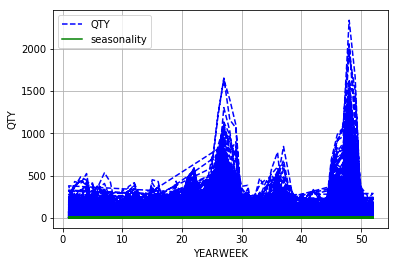

In [36]:
%matplotlib inline

x = maGroup["week"]
y = maGroup["qty"]
# y2 = maGroup["MA"]
y2 = maGroup["seasonality"]

plt.plot(x, y, 'b--', lw=1.5, label = 'QTY')
plt.grid(True)
plt.ylabel('QTY') # y축 이름
plt.xlabel('YEARWEEK')
plt.plot(x, y2, 'g', lw=1.5, label = 'seasonality')
plt.legend(loc=0) #라벨 위치

# plt.plot(x, y3, 'y', lw=1.5, label = 'SEASONALITY')
plt.legend(loc=0)

## 6. 수요예측

### step1. FCST 구하기

In [37]:
def preweek(inputYW, gapW):
    inpYW = str(inputYW) ## 입력 연도주차 문자열 변환
    inpY=inpYW[0:4] ## 입력 연도 추출
    inpW=inpYW[4: ] ## 입력 주차 추출

    inpGap=int(gapW) ## 입력 갭 인트형 확정

    dif = int(inpW) - inpGap ## 입력 갭과 입력 주차의 차


    if(dif>0):
        if(dif<10):
            lastanswer = str(inpY) + "0" + str(dif)
        else:
            lastanswer = str(inpY) + str(dif)
        
    else:
        lastweek = dif
        preyear = int(inpY)
        while (lastweek <= 0):
            preyear = preyear - 1
            preweek = Week.last_week_of_year(preyear).week
            lastweek = lastweek + preweek
        if(lastweek<10):
            lastanswer =str(preyear)+"0"+str(lastweek)
        else:
            lastanswer = str(preyear) + str(lastweek)


    return lastanswer

In [38]:
preweek(201650, 10)

'201640'

In [39]:
def recent4FCST(inputdf) :
    inputdf.reset_index(drop = True, inplace = True)

### step2. 미래주차 판매량 예측